In [ ]:
# imports
import json
import requests
import pandas as pd
from transformers import pipeline
from textblob import TextBlob

In [ ]:
# Creating course_gpa dictionioary for later use
course_gpa = {}
i=0
for offset in range(157):
  course_data = requests.get("https://planetterp.com/api/v1/courses", params={"offset": offset*100}).json()
  print(i, ":", course_data[0])

  if "error" in course_data:
    raise ValueError(course_data["error"])

  for course in course_data:
    for prof in course["professors"]:
      if course["average_gpa"] != None:
        if prof in course_gpa:
          course_gpa[prof][0] += course["average_gpa"]
          course_gpa[prof][1] += 1
        else:
          course_gpa[prof] = [course["average_gpa"], 1]

  i+=1

0 : {'average_gpa': 3.7226415094339624, 'professors': ['Jordan Boyd-Graber', 'A Seyed', 'Vanessa Frias-Martinez', 'Geoffrey Malafsky', 'Vanessa Frias-Martinez', 'Naeemul Hassan', 'David Patrick', 'Vanessa Frias-Martinez', 'David Patrick', 'Vanessa Frias-Martinez', 'Vanessa Frias-Martinez', 'Vanessa Frias-Martinez', 'Naeemul Hassan'], 'department': 'INST', 'course_number': '737', 'name': 'INST737', 'title': 'Introduction to Data Science', 'credits': 3, 'description': '<b>Prerequisite:</b> INST627 and (LBSC690, LBSC671, INFM603, or JOUR652).\n<b>Restriction:</b> Permission of INFO-College of Information Studies.\nAn exploration of some of the best and most general approaches to get the most information out of data through clustering, classification, and regression techniques.', 'is_recent': True, 'geneds': None}
1 : {'average_gpa': 3.434117647058823, 'professors': ['Alexander Ruygrok', 'Eugene Cantor', 'Brent Solomon', 'David Sites'], 'department': 'BUAC', 'course_number': '758B', 'name'

In [ ]:
# Create DataFrame for professors and reviews
# [ "prof_name" | "neg_reviews" | "pos_reviews" | "num_ratings" | "avg_expected_grade" | "avg_courses_gpa" | "num_courses" ... | "avg_rating" ]
# "avg_rating" is the target column. It will be dropped during training.

df = pd.DataFrame(columns=["prof_name", "neg_reviews", "pos_reviews", "num_ratings", "avg_expected_grade", "avg_courses_gpa", "num_courses", "avg_rating"])

# Sentiment Analysis classifier
classifier = pipeline("sentiment-analysis")

i=0
for offset in range(130):

  params = {"type": "professor", "reviews": "true", "offset": offset*100}
  prof_data = requests.get("https://planetterp.com/api/v1/professors", params=params).json()

  if "error" in prof_data:
    raise ValueError(prof_data["error"])

  print(offset, ":", prof_data[0])

  for prof in prof_data:
    if len(prof["reviews"]) == 0:
      continue

    entry = ["prof_name", "neg_reviews", "pos_reviews", "num_ratings", "avg_expected_grade", "avg_courses_gpa", "num_courses", "avg_rating"]
    prof_name = prof['name']
    entry[0] = prof_name

    # Sentiment Analysis and expected grades
    reviews = prof["reviews"]
    nreviews = 0
    previews = 0

    total_grades = 0
    num_grades = 0

    for review_dict in reviews:
      review = review_dict["review"]

      exp_letter_grade = review_dict["expected_grade"]
      # Convert letter grade to float (using UMD GPA system)
      if exp_letter_grade == 'A+' or exp_letter_grade == 'A':
        exp_grade = 4.0
      elif exp_letter_grade == 'A-':
        exp_grade = 3.7
      elif exp_letter_grade == 'B+':
        exp_grade = 3.3
      elif exp_letter_grade == 'B':
        exp_grade = 3.0
      elif exp_letter_grade == 'B-':
        exp_grade = 2.7
      elif exp_letter_grade == 'C+':
        exp_grade = 2.3
      elif exp_letter_grade == 'C':
        exp_grade = 2.0
      elif exp_letter_grade == 'C-':
        exp_grade = 1.7
      elif exp_letter_grade == 'D+':
        exp_grade = 1.3
      elif exp_letter_grade == 'D':
        exp_grade = 1.0
      elif exp_letter_grade == 'D-':
        exp_grade = 0.7
      else:
        exp_grade = 0.0

      total_grades += exp_grade
      num_grades += 1

      # Sentiment Analysis
      # Using Transformers Pipeline (better but slower)
      if len(review) > 512:
        continue
      score = classifier(review)[0]
      if score["label"] == 'NEGATIVE':
        nreviews+=1
      elif score["label"] == 'POSITIVE':
        previews+=1

    entry[1] = nreviews
    entry[2] = previews
    entry[3] = nreviews + previews
    entry[4] = total_grades / num_grades
    entry[5] = course_gpa[prof_name][0] / course_gpa[prof_name][1] if prof_name in course_gpa else -1
    entry[6] = len(prof["courses"])
    entry[7] = prof["average_rating"]
    df.loc[i] = entry
    i+=1

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


0 : {'courses': ['INST737', 'ENPM808W', 'ENPM808W', 'ENPM808W', 'ENPM606'], 'average_rating': None, 'type': 'professor', 'reviews': [], 'name': 'A Seyed', 'slug': 'seyed'}
1 : {'courses': ['EDCP318T', 'HESI318T', 'EDCP315'], 'average_rating': None, 'type': 'professor', 'reviews': [], 'name': 'Amanda Even', 'slug': 'even_amanda'}
2 : {'courses': ['JOUR453', 'JOUR453', 'AASP499N', 'JOUR453', 'AASP499N', 'JOUR453', 'AASP499N', 'JOUR453', 'AASP499N', 'JOUR453', 'AASP499N', 'JOUR453'], 'average_rating': 1.5, 'type': 'professor', 'reviews': [{'professor': 'Anne Rosen', 'course': 'JOUR453', 'review': 'the content is interesting, but the professor makes it so boring. half the time she brought in guest speakers, so the class was very dry and uninteresting. one time we watched a 45 minute YouTube video of a speaker going through slides...', 'rating': 1, 'expected_grade': 'A', 'created': '2024-12-16T03:16:28.476190Z'}, {'professor': 'Anne Rosen', 'course': 'JOUR453', 'review': 'guys I dreaded goi

In [ ]:
# Visualizing df
print(df.head())
df[df["prof_name"] == "Maksym Morawski"]

             prof_name  neg_reviews  pos_reviews  num_ratings  \
0        Abani Pradhan            2            1            3   
1     Abhijit Dasgupta            0            3            3   
2       Abigail McEwen            4            2            6   
3  Abolhassan Jawahery            1            2            3   
4          Abram Kagan            3            4            7   

   avg_expected_grade  avg_courses_gpa  num_courses  avg_rating  
0            3.333333         3.628349           14      3.6667  
1            3.675000         3.371156           23      4.2500  
2            3.218182         3.299412           26      2.6364  
3            1.920000         3.123238            9      4.4000  
4            3.470000         3.150684            9      2.7000  


,prof_name,neg_reviews,pos_reviews,num_ratings,avg_expected_grade,avg_courses_gpa,num_courses,avg_rating
3393,Maksym Morawski,48,36,84,2.791626,2.884761,15,2.8079


In [ ]:
# Random Forest Regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


clf = RandomForestRegressor()

predictions = []

total_r2 = 0
total_rmse = 0
total_mae = 0

tenth = int(len(df)/10)
for i in range(10):
  start = i*tenth
  stop = start + tenth

  training_df1 = df[0:start]
  testing_df = df[start:stop]
  training_df2 = df[stop:len(df)]

  training_df = pd.concat([training_df1, training_df2])

  clf.fit(training_df.drop(["prof_name", "avg_rating"], axis=1), training_df["avg_rating"])

  rating_predictions = clf.predict(testing_df.drop(["prof_name", "avg_rating"], axis=1))

  predictions.extend(p for p in rating_predictions)

  print(i)

  # R² score
  r2 = r2_score(testing_df["avg_rating"], rating_predictions)
  total_r2 += r2
  print("R² score:", r2)

  # RMSE
  rmse = np.sqrt(mean_squared_error(testing_df["avg_rating"], rating_predictions))
  total_rmse += rmse
  print("RMSE:", rmse)

  # MAE
  mae = mean_absolute_error(testing_df["avg_rating"], rating_predictions)
  total_mae += mae
  print("MAE:", mae)

print("Average R²: ", total_r2/10)
print("Average RMSE: ", total_rmse/10)
print("Average MAE: ", total_mae/10)

predictions.extend(None for _ in range(len(df)-len(predictions)))
comparison_df = df.copy()
comparison_df["rating_predictions"] = predictions
comparison_df

0
R² score: 0.5794852541698483
RMSE: 0.7223382760979079
MAE: 0.5148520149854142
1
R² score: 0.5067567681124701
RMSE: 0.7471020301220528
MAE: 0.5354200615507594
2
R² score: 0.44559263258421744
RMSE: 0.7887678292783608
MAE: 0.5555127749411526
3
R² score: 0.5239239250448136
RMSE: 0.7102994234251508
MAE: 0.5228159498686764
4
R² score: 0.4772765217603665
RMSE: 0.8678645002036866
MAE: 0.6005150127897682
5
R² score: 0.46756060486251005
RMSE: 0.873747674103749
MAE: 0.5888702874246724
6
R² score: 0.5951211351058633
RMSE: 0.7636412735511269
MAE: 0.5430652036370903
7
R² score: 0.4763056389420124
RMSE: 0.8307282696993522
MAE: 0.5554424259449583
8
R² score: 0.4514487738209909
RMSE: 0.8803725155719421
MAE: 0.5957784343928653
9
R² score: 0.42486952032059966
RMSE: 0.8838857900508408
MAE: 0.6204854888279853
Average R²:  0.4948340774723691
Average RMSE:  0.806874758210417
Average MAE:  0.5632757654363342


,prof_name,neg_reviews,pos_reviews,num_ratings,avg_expected_grade,avg_courses_gpa,num_courses,avg_rating,rating_predictions
0,Abani Pradhan,2,1,3,3.333333,3.628349,14,3.6667,3.146221
1,Abhijit Dasgupta,0,3,3,3.675000,3.371156,23,4.2500,4.413428
2,Abigail McEwen,4,2,6,3.218182,3.299412,26,2.6364,3.042802
3,Abolhassan Jawahery,1,2,3,1.920000,3.123238,9,4.4000,3.976386
4,Abram Kagan,3,4,7,3.470000,3.150684,9,2.7000,3.511166
...,...,...,...,...,...,...,...,...,...
4172,Keven Garcia,0,1,1,3.700000,2.781847,1,4.0000,NaN
4173,Yue Dong,1,2,3,3.800000,2.865296,1,4.2000,NaN
4174,Anurag Dey,0,0,0,4.000000,3.024007,1,1.0000,NaN
4175,Yun Yang,0,0,0,0.000000,3.316981,1,1.0000,NaN


In [ ]:
print(comparison_df[comparison_df['prof_name'] == 'Maksym Morawski'])
print(comparison_df[comparison_df['prof_name'] == 'Justin Wyss-Gallifent'])
print(comparison_df[comparison_df['prof_name'] == 'Fawzi Emad'])
print(comparison_df[comparison_df['prof_name'] == 'Allan Yashinski'])
print(comparison_df[comparison_df['prof_name'] == 'Calin Belta'])
print(comparison_df[comparison_df['prof_name'] == 'Nelson Padua-Perez'])
print(comparison_df[comparison_df['prof_name'] == 'Clyde Kruskal'])

            prof_name  neg_reviews  pos_reviews  num_ratings  \
3393  Maksym Morawski           48           36           84   

      avg_expected_grade  avg_courses_gpa  num_courses  avg_rating  \
3393            2.791626         2.884761           15      2.8079   

      rating_predictions  
3393            3.164587  
                 prof_name  neg_reviews  pos_reviews  num_ratings  \
731  Justin Wyss-Gallifent           47          163          210   

     avg_expected_grade  avg_courses_gpa  num_courses  avg_rating  \
731            3.221886         2.935871           48      4.7172   

     rating_predictions  
731            3.955175  
      prof_name  neg_reviews  pos_reviews  num_ratings  avg_expected_grade  \
425  Fawzi Emad           45           93          138            2.736986   

     avg_courses_gpa  num_courses  avg_rating  rating_predictions  
425         2.657434           11      3.6438            3.778388  
            prof_name  neg_reviews  pos_reviews  num_

In [ ]:
# Decision Tree Regression

from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

predictions = []

total_r2 = 0
total_rmse = 0
total_mae = 0

tenth = int(len(df)/10)
for i in range(10):
  start = i*tenth
  stop = start + tenth

  training_df1 = df[0:start]
  testing_df = df[start:stop]
  training_df2 = df[stop:len(df)]

  training_df = pd.concat([training_df1, training_df2])

  clf.fit(training_df.drop(["prof_name", "avg_rating"], axis=1), training_df["avg_rating"])

  rating_predictions = clf.predict(testing_df.drop(["prof_name", "avg_rating"], axis=1))

  predictions.extend(p for p in rating_predictions)

  print(i)

  # R² score
  r2 = r2_score(testing_df["avg_rating"], rating_predictions)
  total_r2 += r2
  print("R² score:", r2)

  # RMSE
  rmse = np.sqrt(mean_squared_error(testing_df["avg_rating"], rating_predictions))
  total_rmse += rmse
  print("RMSE:", rmse)

  # MAE
  mae = mean_absolute_error(testing_df["avg_rating"], rating_predictions)
  total_mae += mae
  print("MAE:", mae)

print("Average R²: ", total_r2/10)
print("Average RMSE: ", total_rmse/10)
print("Average MAE: ", total_mae/10)

predictions.extend(None for _ in range(len(df)-len(predictions)))
comparison_df = df.copy()
comparison_df["rating_predictions"] = predictions
comparison_df

0
R² score: 0.30827060184429
RMSE: 0.9264417757662335
MAE: 0.6464920863309354
1
R² score: -0.017766806608512375
RMSE: 1.0731822735240435
MAE: 0.7304875299760192
2
R² score: 0.13519141249269206
RMSE: 0.9851325964995024
MAE: 0.7033800959232615
3
R² score: 0.07455985651648123
RMSE: 0.9903243348526981
MAE: 0.6917904076738608
4
R² score: 0.07220735908861542
RMSE: 1.1562224089442499
MAE: 0.7782215827338129
5
R² score: 0.0770321433232598
RMSE: 1.1503877017825208
MAE: 0.7458215827338128
6
R² score: 0.24997762830373194
RMSE: 1.0393550936150269
MAE: 0.6923321342925659
7
R² score: 0.21598503241474032
RMSE: 1.0164411008698127
MAE: 0.636027657873701
8
R² score: 0.19622560484672047
RMSE: 1.0656754581898982
MAE: 0.6772262589928058
9
R² score: -0.05119616994897802
RMSE: 1.1949640634753842
MAE: 0.7756964028776977
Average R²:  0.12604866622730407
Average RMSE:  1.059812680751937
Average MAE:  0.7077475739408473


,prof_name,neg_reviews,pos_reviews,num_ratings,avg_expected_grade,avg_courses_gpa,num_courses,avg_rating,rating_predictions
0,Abani Pradhan,2,1,3,3.333333,3.628349,14,3.6667,2.7143
1,Abhijit Dasgupta,0,3,3,3.675000,3.371156,23,4.2500,5.0000
2,Abigail McEwen,4,2,6,3.218182,3.299412,26,2.6364,2.8333
3,Abolhassan Jawahery,1,2,3,1.920000,3.123238,9,4.4000,4.0000
4,Abram Kagan,3,4,7,3.470000,3.150684,9,2.7000,4.2500
...,...,...,...,...,...,...,...,...,...
4172,Keven Garcia,0,1,1,3.700000,2.781847,1,4.0000,NaN
4173,Yue Dong,1,2,3,3.800000,2.865296,1,4.2000,NaN
4174,Anurag Dey,0,0,0,4.000000,3.024007,1,1.0000,NaN
4175,Yun Yang,0,0,0,0.000000,3.316981,1,1.0000,NaN


In [ ]:
# Support Vector Machine
from sklearn.svm import SVR

clf = SVR()

predictions = []

total_r2 = 0
total_rmse = 0
total_mae = 0

tenth = int(len(df)/10)
for i in range(10):
  start = i*tenth
  stop = start + tenth

  training_df1 = df[0:start]
  testing_df = df[start:stop]
  training_df2 = df[stop:len(df)]

  training_df = pd.concat([training_df1, training_df2])

  clf.fit(training_df.drop(["prof_name", "avg_rating"], axis=1), training_df["avg_rating"])

  rating_predictions = clf.predict(testing_df.drop(["prof_name", "avg_rating"], axis=1))

  predictions.extend(p for p in rating_predictions)

  print(i)

  # R² score
  r2 = r2_score(testing_df["avg_rating"], rating_predictions)
  total_r2 += r2
  print("R² score:", r2)

  # RMSE
  rmse = np.sqrt(mean_squared_error(testing_df["avg_rating"], rating_predictions))
  total_rmse += rmse
  print("RMSE:", rmse)

  # MAE
  mae = mean_absolute_error(testing_df["avg_rating"], rating_predictions)
  total_mae += mae
  print("MAE:", mae)

print("Average R²: ", total_r2/10)
print("Average RMSE: ", total_rmse/10)
print("Average MAE: ", total_mae/10)

predictions.extend(None for _ in range(len(df)-len(predictions)))
comparison_df = df.copy()
comparison_df["rating_predictions"] = predictions
comparison_df

0
R² score: 0.47083150982297406
RMSE: 0.8103021692702119
MAE: 0.5682798725254
1
R² score: 0.42280460240735296
RMSE: 0.8081849874953326
MAE: 0.5601130903186164
2
R² score: 0.3768153622281847
RMSE: 0.8362633467312811
MAE: 0.5942229349727769
3
R² score: 0.5023428540750662
RMSE: 0.7262203359579699
MAE: 0.5316924370803001
4
R² score: 0.3263265155814624
RMSE: 0.9852368511324419
MAE: 0.6696520112169919
5
R² score: 0.4517992258534671
RMSE: 0.8865857858756341
MAE: 0.5945707453619321
6
R² score: 0.49654818424376024
RMSE: 0.8515414557591144
MAE: 0.5665862281779209
7
R² score: 0.4033968450807194
RMSE: 0.8866716316507041
MAE: 0.5905520338771214
8
R² score: 0.43893518126946063
RMSE: 0.8903574549732728
MAE: 0.5824399364703231
9
R² score: 0.39814178911460374
RMSE: 0.9041907394802414
MAE: 0.6135948147140847
Average R²:  0.4287942069677051
Average RMSE:  0.8585554758326204
Average MAE:  0.5871704104715467


,prof_name,neg_reviews,pos_reviews,num_ratings,avg_expected_grade,avg_courses_gpa,num_courses,avg_rating,rating_predictions
0,Abani Pradhan,2,1,3,3.333333,3.628349,14,3.6667,3.459648
1,Abhijit Dasgupta,0,3,3,3.675000,3.371156,23,4.2500,4.760517
2,Abigail McEwen,4,2,6,3.218182,3.299412,26,2.6364,3.079800
3,Abolhassan Jawahery,1,2,3,1.920000,3.123238,9,4.4000,3.529202
4,Abram Kagan,3,4,7,3.470000,3.150684,9,2.7000,3.609437
...,...,...,...,...,...,...,...,...,...
4172,Keven Garcia,0,1,1,3.700000,2.781847,1,4.0000,NaN
4173,Yue Dong,1,2,3,3.800000,2.865296,1,4.2000,NaN
4174,Anurag Dey,0,0,0,4.000000,3.024007,1,1.0000,NaN
4175,Yun Yang,0,0,0,0.000000,3.316981,1,1.0000,NaN


In [ ]:
# Elastic Net
from sklearn.linear_model import ElasticNet

clf = ElasticNet()

predictions = []

total_r2 = 0
total_rmse = 0
total_mae = 0

tenth = int(len(df)/10)
for i in range(10):
  start = i*tenth
  stop = start + tenth

  training_df1 = df[0:start]
  testing_df = df[start:stop]
  training_df2 = df[stop:len(df)]

  training_df = pd.concat([training_df1, training_df2])

  clf.fit(training_df.drop(["prof_name", "avg_rating"], axis=1), training_df["avg_rating"])

  rating_predictions = clf.predict(testing_df.drop(["prof_name", "avg_rating"], axis=1))

  predictions.extend(p for p in rating_predictions)

  print(i)

  # R² score
  r2 = r2_score(testing_df["avg_rating"], rating_predictions)
  total_r2 += r2
  print("R² score:", r2)

  # RMSE
  rmse = np.sqrt(mean_squared_error(testing_df["avg_rating"], rating_predictions))
  total_rmse += rmse
  print("RMSE:", rmse)

  # MAE
  mae = mean_absolute_error(testing_df["avg_rating"], rating_predictions)
  total_mae += mae
  print("MAE:", mae)

print("Average R²: ", total_r2/10)
print("Average RMSE: ", total_rmse/10)
print("Average MAE: ", total_mae/10)

predictions.extend(None for _ in range(len(df)-len(predictions)))
comparison_df = df.copy()
comparison_df["rating_predictions"] = predictions
comparison_df

0
R² score: 0.1331049029000051
RMSE: 1.0371302153462099
MAE: 0.8288006884395224
1
R² score: 0.09507787010117252
RMSE: 1.0119404441749154
MAE: 0.7810893514459317
2
R² score: 0.11870084104052958
RMSE: 0.9944807260650694
MAE: 0.7695524201194445
3
R² score: 0.1597169006877217
RMSE: 0.9436611985605514
MAE: 0.7462827085846513
4
R² score: 0.0840357360941002
RMSE: 1.1488284593520843
MAE: 0.9205753600720497
5
R² score: 0.1199928446459484
RMSE: 1.1232955636585251
MAE: 0.9372331600027847
6
R² score: 0.09901293478972883
RMSE: 1.1391636487860488
MAE: 0.9287251870666914
7
R² score: 0.08933486285694658
RMSE: 1.0954672447930351
MAE: 0.9309087589099317
8
R² score: 0.11637372001248691
RMSE: 1.1173576136510077
MAE: 0.9227435897719362
9
R² score: 0.07886779293110668
RMSE: 1.1185977556880589
MAE: 0.932670921821594
Average R²:  0.10942184060597464
Average RMSE:  1.0729922870075508
Average MAE:  0.8698582146234536


,prof_name,neg_reviews,pos_reviews,num_ratings,avg_expected_grade,avg_courses_gpa,num_courses,avg_rating,rating_predictions
0,Abani Pradhan,2,1,3,3.333333,3.628349,14,3.6667,3.835411
1,Abhijit Dasgupta,0,3,3,3.675000,3.371156,23,4.2500,4.026890
2,Abigail McEwen,4,2,6,3.218182,3.299412,26,2.6364,3.725164
3,Abolhassan Jawahery,1,2,3,1.920000,3.123238,9,4.4000,3.931151
4,Abram Kagan,3,4,7,3.470000,3.150684,9,2.7000,3.847980
...,...,...,...,...,...,...,...,...,...
4172,Keven Garcia,0,1,1,3.700000,2.781847,1,4.0000,NaN
4173,Yue Dong,1,2,3,3.800000,2.865296,1,4.2000,NaN
4174,Anurag Dey,0,0,0,4.000000,3.024007,1,1.0000,NaN
4175,Yun Yang,0,0,0,0.000000,3.316981,1,1.0000,NaN


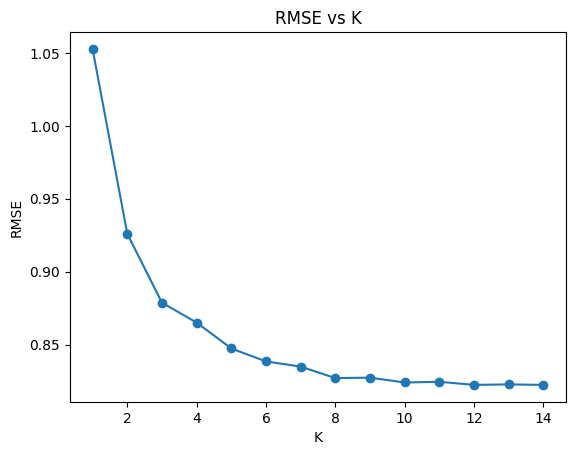

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

# Creating a plot for Error vs K to pick a k-value
yvals = []

for k in range(1,15):
  clf = KNeighborsRegressor(n_neighbors=k)

  total_r2 = 0
  total_rmse = 0
  total_mae = 0

  tenth = int(len(df)/10)
  for i in range(10):
    start = i*tenth
    stop = start + tenth

    training_df1 = df[0:start]
    testing_df = df[start:stop]
    training_df2 = df[stop:len(df)]

    training_df = pd.concat([training_df1, training_df2])

    clf.fit(training_df.drop(["prof_name", "avg_rating"], axis=1), training_df["avg_rating"])

    rating_predictions = clf.predict(testing_df.drop(["prof_name", "avg_rating"], axis=1))

    # R² score
    r2 = r2_score(testing_df["avg_rating"], rating_predictions)
    total_r2 += r2

    # RMSE
    rmse = np.sqrt(mean_squared_error(testing_df["avg_rating"], rating_predictions))
    total_rmse += rmse

    # MAE
    mae = mean_absolute_error(testing_df["avg_rating"], rating_predictions)
    total_mae += mae

  yvals.append(total_rmse/10)


plt.plot(list(range(1, 15)), yvals, marker='o')
plt.title("RMSE vs K")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.show()

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsRegressor

clf = KNeighborsRegressor(n_neighbors=8)

predictions = []

total_r2 = 0
total_rmse = 0
total_mae = 0

tenth = int(len(df)/10)
for i in range(10):
  start = i*tenth
  stop = start + tenth

  training_df1 = df[0:start]
  testing_df = df[start:stop]
  training_df2 = df[stop:len(df)]

  training_df = pd.concat([training_df1, training_df2])

  clf.fit(training_df.drop(["prof_name", "avg_rating"], axis=1), training_df["avg_rating"])

  rating_predictions = clf.predict(testing_df.drop(["prof_name", "avg_rating"], axis=1))

  predictions.extend(p for p in rating_predictions)

  print(i)

  # R² score
  r2 = r2_score(testing_df["avg_rating"], rating_predictions)
  total_r2 += r2
  print("R² score:", r2)

  # RMSE
  rmse = np.sqrt(mean_squared_error(testing_df["avg_rating"], rating_predictions))
  total_rmse += rmse
  print("RMSE:", rmse)

  # MAE
  mae = mean_absolute_error(testing_df["avg_rating"], rating_predictions)
  total_mae += mae
  print("MAE:", mae)

print("Average R²: ", total_r2/10)
print("Average RMSE: ", total_rmse/10)
print("Average MAE: ", total_mae/10)

predictions.extend(None for _ in range(len(df)-len(predictions)))
comparison_df = df.copy()
comparison_df["rating_predictions"] = predictions
comparison_df

0
R² score: 0.5025093732320361
RMSE: 0.7856741510757116
MAE: 0.5751694544364508
1
R² score: 0.4391855462915476
RMSE: 0.7966342021788201
MAE: 0.5901616306954436
2
R² score: 0.3506331168970598
RMSE: 0.8536498353129409
MAE: 0.6299089628297362
3
R² score: 0.5257265742170003
RMSE: 0.7089533832597293
MAE: 0.5171584832134292
4
R² score: 0.4134037773846909
RMSE: 0.9193598882863544
MAE: 0.6552712230215828
5
R² score: 0.48939593916509516
RMSE: 0.8556439308039109
MAE: 0.6232153776978419
6
R² score: 0.5895198750134475
RMSE: 0.7689053927108966
MAE: 0.536875
7
R² score: 0.46104011977305936
RMSE: 0.8427490271966959
MAE: 0.5926712230215827
8
R² score: 0.4849596119955749
RMSE: 0.8530579289604224
MAE: 0.5982745503597122
9
R² score: 0.422304586930373
RMSE: 0.8858545486174382
MAE: 0.6207757793764989
Average R²:  0.4678678520899885
Average RMSE:  0.827048228840292
Average MAE:  0.5939481684652279


,prof_name,neg_reviews,pos_reviews,num_ratings,avg_expected_grade,avg_courses_gpa,num_courses,avg_rating,rating_predictions
0,Abani Pradhan,2,1,3,3.333333,3.628349,14,3.6667,3.506062
1,Abhijit Dasgupta,0,3,3,3.675000,3.371156,23,4.2500,4.347575
2,Abigail McEwen,4,2,6,3.218182,3.299412,26,2.6364,3.122912
3,Abolhassan Jawahery,1,2,3,1.920000,3.123238,9,4.4000,3.976525
4,Abram Kagan,3,4,7,3.470000,3.150684,9,2.7000,3.527250
...,...,...,...,...,...,...,...,...,...
4172,Keven Garcia,0,1,1,3.700000,2.781847,1,4.0000,NaN
4173,Yue Dong,1,2,3,3.800000,2.865296,1,4.2000,NaN
4174,Anurag Dey,0,0,0,4.000000,3.024007,1,1.0000,NaN
4175,Yun Yang,0,0,0,0.000000,3.316981,1,1.0000,NaN
